In [1]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import RobustScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.impute import IterativeImputer

# Load dataset
df = pd.read_csv('f1_2019_to_2023_all_drivers_all_data.csv', low_memory=False)

# Convert time columns to seconds
time_columns = ['LapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time']
for col in time_columns:
    df[col] = pd.to_timedelta(df[col]).dt.total_seconds()

# Convert binary columns to integer type
df['Rainfall'] = df['Rainfall'].astype(int)
df['FreshTyre'] = df['FreshTyre'].astype(int)
df['IsAccurate'] = df['IsAccurate'].astype(int)


# Categorize weather condition based on centroid values of Kmeans clustering
def categorize_weather(row):
    if row['Rainfall'] > 0:
        return 'Rainy'
    elif row['AirTemp'] > 28.43213126:
        return 'high'
    elif row['AirTemp'] > 21.31279265:
        return 'medium'
    elif row['AirTemp'] > 12.84901403:
        return 'low'
    else:
        return 'very_low'

df['Weather_Category'] = df.apply(categorize_weather, axis=1)
df['Original_Weather_Category'] = df['Weather_Category']
df = pd.get_dummies(df, columns=['Weather_Category'])


# Keep the original Driver and Circuit for EDA
df['Original_Driver'] = df['Driver']
df['Original_Circuit'] = df['Circuit']

# Create Track temperature category based on the result of Kmeans clustering 
df['TrackTemp_Cat'] = pd.cut(df['TrackTemp'], bins=[0, 18.96764999, 27.87457484, 35.04425766, 41.75142602, 50.51006013], labels=['VERY_LOW', 'Low', 'Medium', 'Warm', 'High'])
df['Original_TrackTemp_Cat'] = df['TrackTemp_Cat']
df = pd.get_dummies(df, columns=['TrackTemp_Cat'])


#Feature Engineering with weather condition features
df['TrackConditionIndex'] = (df['AirTemp'] + df['TrackTemp'] + df['Humidity'] + df['Pressure'] +
                             df['WindSpeed'] + df['Rainfall']) / 6

# Tyre Age Interaction with TrackTemp 
df['TyreAge_TrackTemp'] = df['TyreLife'] * df['TrackTemp']

df['Temp_Rainfall_Interaction'] = df['TrackTemp'] * df['Rainfall']

# One-hot encoding
df = pd.get_dummies(df, columns=['Driver', 'Compound', 'Team','TrackStatus','Circuit'])

# Drop irrelevant columns
columns_to_drop = ['Time', 'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
                   'PitOutTime', 'PitInTime', 'LapStartDate', 'Deleted', 'DeletedReason', 'FastF1Generated',
                   'IsPersonalBest', 'Sector3Time','LapStartTime','Sector2Time','Sector1Time']
df.drop(columns=columns_to_drop, inplace=True)



# Select numerical values for scaling and imputation
numeric_features = ['Humidity', 'Pressure', 'WindDirection', 'WindSpeed','TrackTemp','AirTemp','TrackConditionIndex','TyreAge_TrackTemp','Rainfall','SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST']

#time_series_features = ['WindDirection', 'WindSpeed', 'TrackTemp', 'AirTemp', 'Rainfall', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST']

df[numeric_features] = df[numeric_features].fillna(method='ffill')


## Separate Rainy / dry days ##
# 1. Separate LapTime as dry or wet(rainy) condition ( since lapTime of rainy day would be recognized as outliers)
# 2. Remove Outliers for dry condition LapTime
# 3. Build Combined LapTime df (Outliers for dry days are deleted)

# Flag for rainy conditions
df['IsRainy'] = df['Rainfall'].apply(lambda x: 1 if x > 0 else 0)

# Separate dataframes for dry and wet conditions
df_dry = df[df['IsRainy'] == 0]
df_wet = df[df['IsRainy'] == 1]

# Remove Outliers for dry days using the IQR method that effective to removes extreme outliers
Q1_dry = df_dry['LapTime'].quantile(0.25)
Q3_dry = df_dry['LapTime'].quantile(0.75)
IQR_dry = Q3_dry - Q1_dry
lower_bound_dry = Q1_dry - 1.5 * IQR_dry
upper_bound_dry = Q3_dry + 1.5 * IQR_dry
df_dry_filtered = df_dry[(df_dry['LapTime'] >= lower_bound_dry) & (df_dry['LapTime'] <= upper_bound_dry)]
df_dry_filtered = df_dry_filtered.copy()
df_wet = df_wet.copy()


## Scaling to the selected numeric features ##
robust_scaler = RobustScaler()

# Applying scaling to the numeric features
df_dry_filtered[numeric_features] = robust_scaler.fit_transform(df_dry_filtered[numeric_features])
df_wet[numeric_features] = robust_scaler.transform(df_wet[numeric_features])  # Use transform, not fit_transform

# Combining the datasets after scaling
df_combined = pd.concat([df_dry_filtered, df_wet], ignore_index=True)
df_combined.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96556 entries, 0 to 96555
Data columns (total 150 columns):
 #    Column                               Dtype   
---   ------                               -----   
 0    DriverNumber                         int64   
 1    LapTime                              float64 
 2    LapNumber                            float64 
 3    Stint                                float64 
 4    SpeedI1                              float64 
 5    SpeedI2                              float64 
 6    SpeedFL                              float64 
 7    SpeedST                              float64 
 8    TyreLife                             float64 
 9    FreshTyre                            int64   
 10   Position                             float64 
 11   IsAccurate                           int64   
 12   AirTemp                              float64 
 13   Humidity                             float64 
 14   Pressure                             float64 
 15   

/var/folders/_5/533f3cq93vq25vl2f3txpkb40000gn/T/ipykernel_6434/3344605182.py:79: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[numeric_features] = df[numeric_features].fillna(method='ffill')


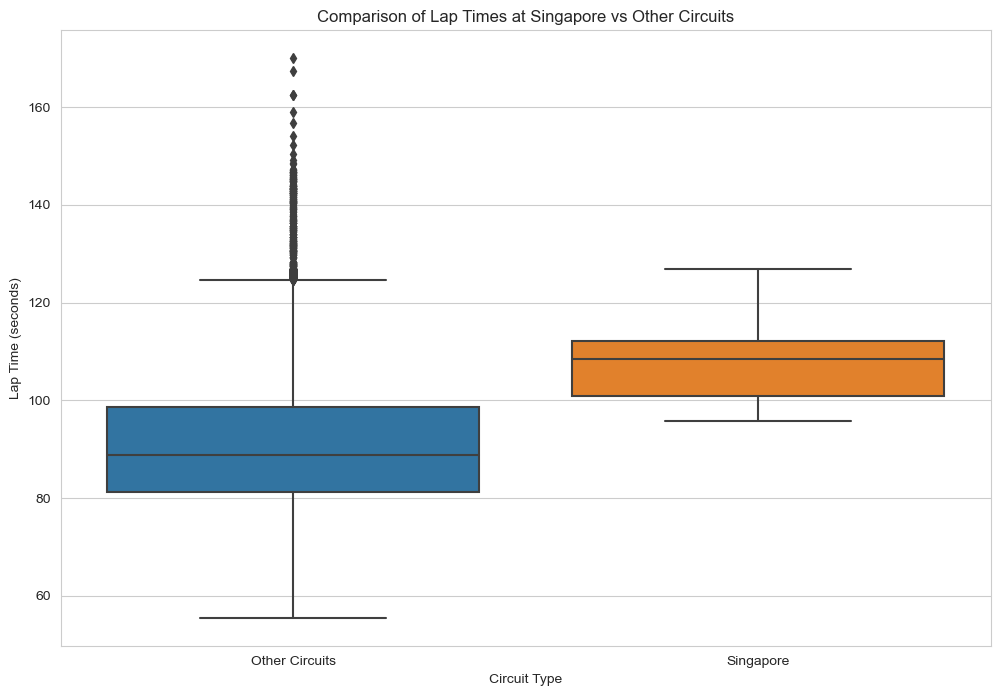

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assume df_combined is your DataFrame after all preprocessing steps you've applied
# Let's mark the Singapore circuit explicitly for comparison
df_combined['Is_Singapore'] = df_combined['Original_Circuit'].apply(lambda x: 'Singapore' if 'Singapore' in x else 'Other Circuits')

# Create a boxplot comparing lap times
plt.figure(figsize=(12, 8))
sns.boxplot(x='Is_Singapore', y='LapTime', data=df_combined)
plt.title('Comparison of Lap Times at Singapore vs Other Circuits')
plt.xlabel('Circuit Type')
plt.ylabel('Lap Time (seconds)')
plt.show()


In [3]:
import pandas as pd
import scipy.stats as stats

# Descriptive statistics
descriptive_stats = df_combined.groupby('Is_Singapore').agg({
    'LapTime': ['mean', 'median', 'std', 'min', 'max'],
    'Humidity': ['mean', 'median', 'std', 'min', 'max']
})

print("Descriptive Statistics:\n", descriptive_stats)

# T-test for comparing means
t_stat, p_value = stats.ttest_ind(
    df_combined[df_combined['Is_Singapore'] == 'Singapore']['LapTime'],
    df_combined[df_combined['Is_Singapore'] == 'Other Circuits']['LapTime'],
    equal_var=False  # Welch's t-test assumption for unequal variances
)
print("\nT-test results -- T-statistic:", t_stat, "P-value:", p_value)

# Mann-Whitney U Test for comparing distributions
u_stat, p_value_u = stats.mannwhitneyu(
    df_combined[df_combined['Is_Singapore'] == 'Singapore']['LapTime'],
    df_combined[df_combined['Is_Singapore'] == 'Other Circuits']['LapTime']
)
print("\nMann-Whitney U Test results -- U-statistic:", u_stat, "P-value:", p_value_u)



Descriptive Statistics:
                    LapTime                                       Humidity  \
                      mean   median        std     min      max      mean   
Is_Singapore                                                                
Other Circuits   89.927549   88.849  12.585322  55.404  169.982 -0.101848   
Singapore       108.469874  108.383   7.861321  95.867  126.894  0.793663   

                                                        
                  median       std       min       max  
Is_Singapore                                            
Other Circuits -0.004219  0.728966 -2.113924  1.767932  
Singapore       0.755274  0.332186  0.350211  1.430380  

T-test results -- T-statistic: nan P-value: nan

Mann-Whitney U Test results -- U-statistic: nan P-value: nan


In [13]:
import plotly.express as px

fig = px.scatter(df_combined, x='Humidity', y='LapTime', color='Is_Singapore',
                 title='LapTime comparison between Singapore and other circuits',
                 labels={'Humidity': 'Humidity (%)', 'LapTime': 'Lap Time (seconds)'})
fig.show()


/opt/anaconda3/envs/COMS30035_labs/lib/python3.11/site-packages/seaborn/axisgrid.py:848: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/opt/anaconda3/envs/COMS30035_labs/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/envs/COMS30035_labs/lib/python3.11/site-packages/seaborn/axisgrid.py:848: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/opt/anaconda3/envs/COMS30035_labs/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



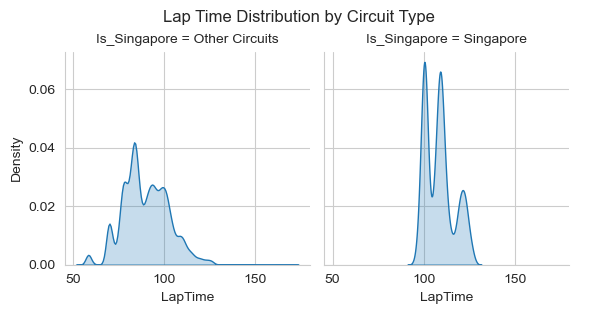

/opt/anaconda3/envs/COMS30035_labs/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/anaconda3/envs/COMS30035_labs/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



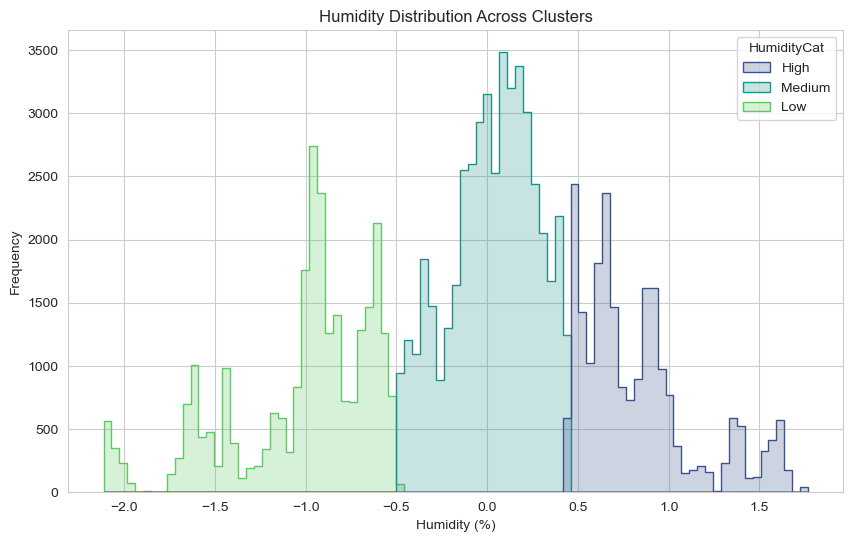

In [8]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Prepare the data (assuming df_combined is already loaded and cleaned)
humidity_data = df_combined[['Humidity']].dropna()  # Ensuring there are no NaN values

# Step 2: Perform K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Choose 3 clusters for example
clusters = kmeans.fit_predict(humidity_data)

# Step 3: Create a new categorical feature
df_combined['HumidityCat'] = clusters

# Optionally add more descriptive labels based on the cluster characteristics
# For example, after inspecting cluster centers:
cluster_centers = kmeans.cluster_centers_
sorted_indices = np.argsort(cluster_centers.squeeze())  # Sort clusters by humidity level
labels = ['Low', 'Medium', 'High']
df_combined['HumidityCat'] = df_combined['HumidityCat'].map({idx: labels[i] for i, idx in enumerate(sorted_indices)})

# Step 4: Visualize the Results
# Plotting histograms for each cluster to visualize distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df_combined, x='Humidity', hue='HumidityCat', element='step', palette='viridis')
plt.title('Humidity Distribution Across Clusters')
plt.xlabel('Humidity (%)')
plt.ylabel('Frequency')
plt.show()


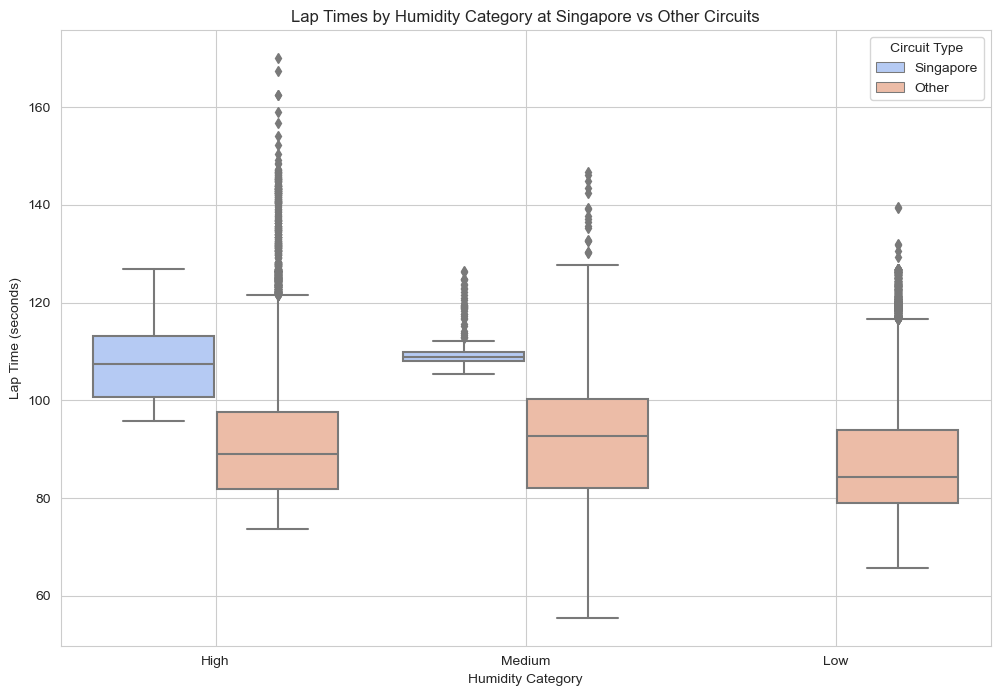

Results for Humidity Category: High
Statistic: nan, p-value: nan

Results for Humidity Category: Medium
Statistic: nan, p-value: nan

Results for Humidity Category: Low
Statistic: nan, p-value: nan


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# Assuming df_combined has 'Circuit' and 'HumidityCat' already defined

# Step 1: Categorize circuits
df_combined['CircuitType'] = df_combined['Original_Circuit'].apply(lambda x: 'Singapore' if 'Singapore' in x else 'Other')

# Step 2: Visualization of Lap Times by Humidity and Circuit Type
plt.figure(figsize=(12, 8))
sns.boxplot(x='HumidityCat', y='LapTime', hue='CircuitType', data=df_combined,
            hue_order=['Singapore', 'Other'], palette='coolwarm')
plt.title('Lap Times by Humidity Category at Singapore vs Other Circuits')
plt.xlabel('Humidity Category')
plt.ylabel('Lap Time (seconds)')
plt.legend(title='Circuit Type')
plt.grid(True)
plt.show()

# Step 3: Statistical Analysis
# Example: Mann-Whitney U Test for each humidity category between Singapore and other circuits
results = {}
humidity_categories = df_combined['HumidityCat'].unique()
for cat in humidity_categories:
    singapore_times = df_combined[(df_combined['CircuitType'] == 'Singapore') & (df_combined['HumidityCat'] == cat)]['LapTime']
    other_times = df_combined[(df_combined['CircuitType'] == 'Other') & (df_combined['HumidityCat'] == cat)]['LapTime']
    stat, p_value = mannwhitneyu(singapore_times, other_times, alternative='two-sided')
    results[cat] = {'Mann-Whitney U Statistic': stat, 'p-value': p_value}

# Print results
for cat, res in results.items():
    print(f"Results for Humidity Category: {cat}\nStatistic: {res['Mann-Whitney U Statistic']}, p-value: {res['p-value']:.4f}\n")


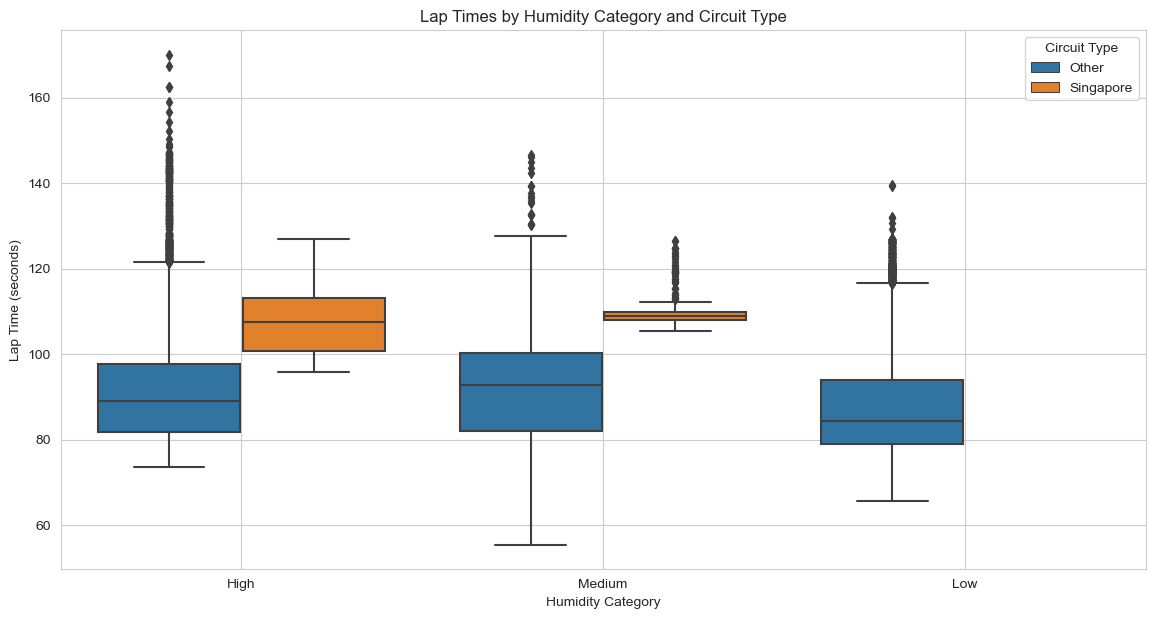

In [10]:
# Categorize circuits into 'Singapore' and 'Other'
df_combined['CircuitType'] = df_combined['Original_Circuit'].apply(lambda x: 'Singapore' if 'Singapore' in x else 'Other')
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame for visualization
visualization_df = df_combined[['LapTime', 'HumidityCat', 'CircuitType']]

# Visualize lap times for Singapore vs Other circuits across different humidity levels
plt.figure(figsize=(14, 7))
sns.boxplot(x='HumidityCat', y='LapTime', hue='CircuitType', data=visualization_df)
plt.title('Lap Times by Humidity Category and Circuit Type')
plt.xlabel('Humidity Category')
plt.ylabel('Lap Time (seconds)')
plt.legend(title='Circuit Type')
plt.grid(True)
plt.show()


In [11]:

# Define specific circuits for comparison
df['CircuitType'] = df['Circuit'].apply(lambda x: 'Singapore' if 'Singapore' in x else ('Monza' if 'Monza' in x else 'Other'))

# Filter out data to include only Singapore and Monza circuits
comparison_df = df[df['CircuitType'].isin(['Singapore', 'Monza'])]

# Categorize Humidity for better visual representation and analysis
def categorize_humidity(humidity):
    if humidity < 60:
        return 'Low'
    elif humidity <= 80:
        return 'Moderate'
    else:
        return 'High'

comparison_df['HumidityCategory'] = comparison_df['Humidity'].apply(categorize_humidity)

# Plotting the comparison
plt.figure(figsize=(12, 6))
sns.boxplot(x='HumidityCategory', y='LapTime', hue='CircuitType', data=comparison_df)
plt.title('Lap Time Comparison between Singapore GP and Monza GP by Humidity Levels')
plt.xlabel('Humidity Category')
plt.ylabel('Lap Time (seconds)')
plt.legend(title='Circuit')
plt.show()

# Displaying statistical summary for deeper insights
print(comparison_df.groupby(['CircuitType', 'HumidityCategory'])['LapTime'].describe())


KeyError: 'Circuit'